In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-11-04 05:39:52.880682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 05:39:52.941765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 05:39:53.032179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 05:39:53.033205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
import os
import cv2
import sys
import random
import warnings
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNEL = 1
IMG_PATH = '../input/mci-aug/mci_2/jpg'
MASK_PATH = '../input/mci-aug/mci_2/mask'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
train_df = pd.read_excel('../input/mci-aug/mci_2/train.xlsx')

In [ ]:
train_df.head()

,mask,jpg,target
0,1004--9-3-15_jpg.rf.2190867bb3369d0dede856a98a...,1004--9-3-15_jpg.rf.2190867bb3369d0dede856a98a...,1
1,1004--9-3-15_jpg.rf.80520d4ae77efe4310b28f461f...,1004--9-3-15_jpg.rf.80520d4ae77efe4310b28f461f...,1
2,1004--9-3-15_jpg.rf.a5334fa03f2a9286da12bbb8f3...,1004--9-3-15_jpg.rf.a5334fa03f2a9286da12bbb8f3...,1
3,1004--9-3-15_jpg.rf.a6884b36200aed8e551e8e6268...,1004--9-3-15_jpg.rf.a6884b36200aed8e551e8e6268...,1
4,1006--13-8-13_jpg.rf.7fb59f4d04d188edf6b7c066f...,1006--13-8-13_jpg.rf.7fb59f4d04d188edf6b7c066f...,1


In [ ]:
train_df_data = train_df[train_df['target'] == 1]
img_data = list(train_df_data.T.to_dict().values())

In [ ]:
img_data

[{'mask': '1004--9-3-15_jpg.rf.2190867bb3369d0dede856a98a569a16.png',
  'jpg': '1004--9-3-15_jpg.rf.2190867bb3369d0dede856a98a569a16.jpg',
  'target': 1},
 {'mask': '1004--9-3-15_jpg.rf.80520d4ae77efe4310b28f461f54449b.png',
  'jpg': '1004--9-3-15_jpg.rf.80520d4ae77efe4310b28f461f54449b.jpg',
  'target': 1},
 {'mask': '1004--9-3-15_jpg.rf.a5334fa03f2a9286da12bbb8f37f3b0e.png',
  'jpg': '1004--9-3-15_jpg.rf.a5334fa03f2a9286da12bbb8f37f3b0e.jpg',
  'target': 1},
 {'mask': '1004--9-3-15_jpg.rf.a6884b36200aed8e551e8e6268bbcff8.png',
  'jpg': '1004--9-3-15_jpg.rf.a6884b36200aed8e551e8e6268bbcff8.jpg',
  'target': 1},
 {'mask': '1006--13-8-13_jpg.rf.7fb59f4d04d188edf6b7c066fa216f97.png',
  'jpg': '1006--13-8-13_jpg.rf.7fb59f4d04d188edf6b7c066fa216f97.jpg',
  'target': 1},
 {'mask': '1006--13-8-13_jpg.rf.a7793c5adc1e5ec3d9662364f60a8e4b.png',
  'jpg': '1006--13-8-13_jpg.rf.a7793c5adc1e5ec3d9662364f60a8e4b.jpg',
  'target': 1},
 {'mask': '1006--13-8-13_jpg.rf.c3932530450e112189caa8d07e980d7d.p

In [ ]:
from PIL import Image

In [ ]:
print("Getting and Resizing Train Images, Train Mask, and Adding Label ...\n\n")

# Create X_train, Y_train, and Label
X_train_seg = np.zeros((len(train_df_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
Y_train_seg = np.zeros((len(train_df_data), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
Label_seg = np.zeros(len(train_df_data), dtype=np.uint8)

img_data = list(train_df_data.T.to_dict().values())

for i, data_row in tqdm(enumerate(img_data), total=len(img_data)):

    patientImage = data_row['jpg']
    imageLabel  = data_row['target']
    imagemask = data_row['mask']

    imagePath = os.path.join(IMG_PATH, patientImage)
    img = Image.open(imagePath).convert('L')
    lungImage = np.array(img)
    lungImage = np.expand_dims(resize(lungImage, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

    X_train_seg[i] = lungImage

    Label_seg[i] = imageLabel

    maskPath = os.path.join(MASK_PATH, imagemask)
    maskImage = imread(maskPath)
    maskImage = np.expand_dims(resize(maskImage, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

    Y_train_seg[i] = maskImage[:,:,1]

print('\n\nProcess ... C O M P L E T E')

Getting and Resizing Train Images, Train Mask, and Adding Label ...




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
100%|██████████| 2604/2604 [00:58<00:00, 44.33it/s]



Process ... C O M P L E T E


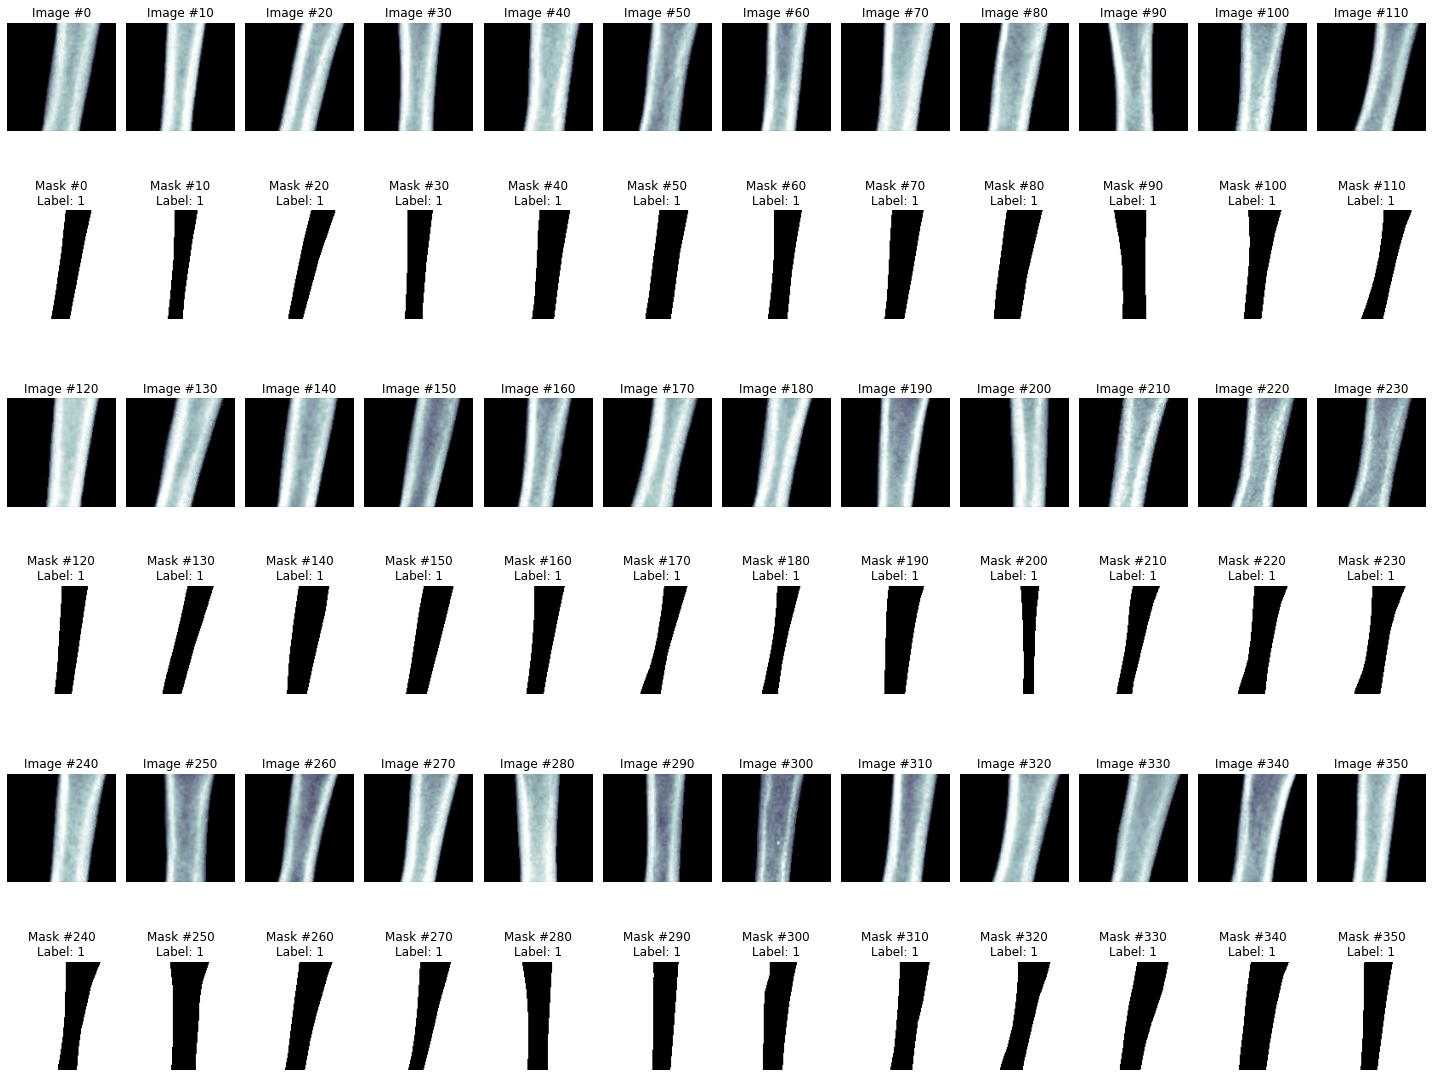

In [ ]:
plt.figure(figsize=(20, 16))
x, y = 12, 3
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train_seg[pos], cmap=plt.cm.bone)
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)

        plt.imshow(np.squeeze(Y_train_seg[pos]), cmap='gray_r')
        plt.title('Mask #{}\nLabel: {}'.format(pos, Label_seg[pos]))
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def iou_score(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
def AttnBlock2D(x, g, inter_channel, data_format='channels_first'):

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    f = Activation('relu')(add([theta_x, phi_g]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x


def attention_up_and_concate(down_layer, layer, data_format='channels_first'):

    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)
    layer = AttnBlock2D(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[3]], axis=3))

    concate = my_concat([up, layer])
    return concate

In [ ]:
def att_unet(img_w, img_h, n_label, data_format='channels_first'):
    inputs = Input((IMG_CHANNEL, img_w, img_h))
    x = inputs
    depth = 4
    features = 32
    skips = []
    for i in range(depth):

        # ENCODER
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format='channels_first')(x)
        features = features * 2

    # BOTTLENECK
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    # DECODER
    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    return model

In [ ]:
model = att_unet(IMG_WIDTH, IMG_HEIGHT, n_label=1)

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[dice_coef_loss, iou_score]
)

In [ ]:
X_train_seg = np.rollaxis(X_train_seg, 3, 1)
Y_train_seg = np.rollaxis(Y_train_seg, 3, 1)
print(X_train_seg.shape)
print(Y_train_seg.shape)

(2604, 1, 128, 128)
(2604, 1, 128, 128)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.9, min_delta=1e-10 ,patience=3,
                                   verbose=1, mode='auto')

callbacks = [reduceLROnPlat]

In [ ]:
epochs = 120
model.fit(X_train_seg, Y_train_seg, validation_split=0.1, batch_size=32, epochs=epochs, callbacks=callbacks)

In [ ]:
# The first 90% used for training
pred_train = model.predict(X_train_seg[:int(X_train_seg.shape[0]*0.9)].astype(np.float16), verbose=1)
# The last 10% used for validation
pred_val = model.predict(X_train_seg[int(X_train_seg.shape[0]*0.9):].astype(np.float16), verbose=1)

# pred_test = model.predict(X_test, verbose=1)

# Thresholds prediction
pred_train_threshold = (pred_train > 0.40).astype(np.float16)
pred_val_threshold = (pred_val > 0.40).astype(np.float16)

9/9 [==============================] - 0s 25ms/step


In [ ]:
# CHANGE TO CHANNEL LAST
X_train_seg = np.rollaxis(X_train_seg, 3, 1)
X_train_seg = np.rollaxis(X_train_seg, 3, 2)
X_train_seg = np.swapaxes(X_train_seg, 1, 2)

Y_train_seg  = np.rollaxis(Y_train_seg, 3, 1)
Y_train_seg = np.rollaxis(Y_train_seg, 3, 2)
Y_train_seg = np.swapaxes(Y_train_seg, 1, 2)

pred_train_threshold = np.rollaxis(pred_train_threshold, 3, 1)
pred_train_threshold = np.rollaxis(pred_train_threshold, 3, 2)
pred_train_threshold = np.swapaxes(pred_train_threshold, 1, 2)

pred_val_threshold = np.rollaxis(pred_val_threshold, 3, 1)
pred_val_threshold = np.rollaxis(pred_val_threshold, 3, 2)
pred_val_threshold = np.swapaxes(pred_val_threshold, 1, 2)

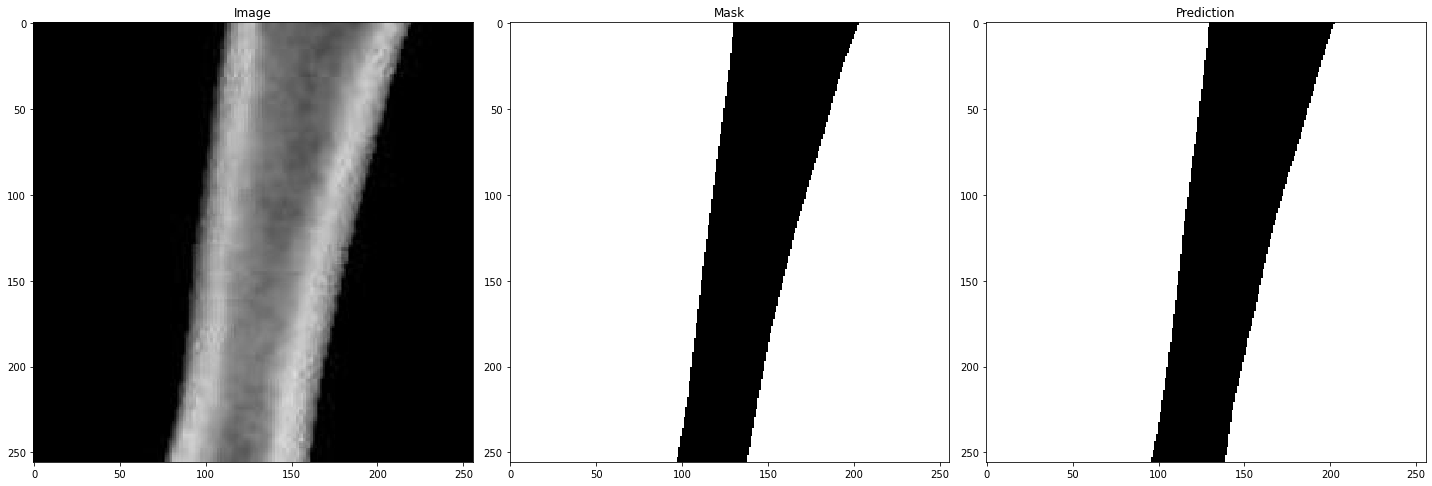

In [ ]:
ix = random.randint(0, 365)
plt.figure(figsize=(20, 28))

# Our original training image
plt.subplot(131)
imshow(X_train_seg[ix])
plt.title('Image')

# Our original combined mask
plt.subplot(132)
imshow(np.squeeze(Y_train_seg[ix]), cmap='gray_r')
plt.title('Mask')

# The mask of our model U-Net prediction
plt.subplot(133)
imshow(np.squeeze(pred_train_threshold[ix] > 0.40), cmap='gray_r')
plt.title('Prediction')
plt.show()

In [ ]:
model.save("out/mci_128.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import os
import zipfile
import datetime

def file2zip(packagePath, zipPath):

    zip = zipfile.ZipFile(zipPath, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(packagePath):
        fpath = path.replace(packagePath, '')
        for name in fileNames:
            fullName = os.path.join(path, name)
            name = fpath + '\\' + name
            zip.write(fullName, name)
    zip.close()


if __name__ == "__main__":

    packagePath = '/kaggle/working/out'
    zipPath = '/kaggle/working/output.zip'
    if os.path.exists(zipPath):
        os.remove(zipPath)
    file2zip(packagePath, zipPath)
    print("complated")
    print(datetime.datetime.utcnow())